In [1]:
import numpy as np
import pandas as pd
import scanpy as sc
import anndata as ad
import scvi
import os
import json

/Users/lukar818/.pyenv/versions/3.13.5/envs/totalvi/lib/python3.13/site-packages/scanpy/_utils/__init__.py:33: FutureWarning: `__version__` is deprecated, use `importlib.metadata.version('anndata')` instead.
  from anndata import __version__ as anndata_version
/Users/lukar818/.pyenv/versions/3.13.5/envs/totalvi/lib/python3.13/site-packages/scanpy/__init__.py:24: FutureWarning: `__version__` is deprecated, use `importlib.metadata.version('anndata')` instead.
  if Version(anndata.__version__) >= Version("0.11.0rc2"):
/Users/lukar818/.pyenv/versions/3.13.5/envs/totalvi/lib/python3.13/site-packages/scanpy/readwrite.py:16: FutureWarning: `__version__` is deprecated, use `importlib.metadata.version('anndata')` instead.
  if Version(anndata.__version__) >= Version("0.11.0rc2"):


In [2]:
path = "/Users/lukar818/Documents/postdoc/MCAR/data/visiumtwo" # set to location of glioblastoma data

In [4]:
with open(os.path.join(os.getcwd(), "..", "predids.json")) as json_file:
    json_data = json.load(json_file)

In [39]:
adata_all = sc.read_10x_mtx(
    os.path.join(path, "filtered_feature_bc_matrix"),
    var_names="gene_symbols",
    gex_only=False
)

In [40]:
json_data['glioblastoma'].keys()

dict_keys(['CR2', 'CD163', 'PCNA', 'BCL2', 'FCGR3A', 'EPCAM', 'CD40', 'CD4', 'CD274'])

## PCNA Glioblastoma example

In [53]:
test_barcodes = np.array(json_data['glioblastoma']['PCNA'])
mask_test = np.isin(adata_all.obs_names, test_barcodes)
mask_train = ~mask_test


In [57]:
sc.pp.highly_variable_genes(
    adata_all,
    flavor="seurat_v3",
    n_top_genes=4000,
    subset=True
)


In [ ]:
train_idx = np.where(mask_train)[0]
test_idx  = np.where(mask_test)[0]

rna = adata_all[:, adata_all.var["feature_types"] == "Gene Expression"]
prot = adata_all[:, adata_all.var["feature_types"] == "Antibody Capture"]

adata_train = ad.AnnData(
    X=rna.X[train_idx],
    obs=rna.obs.iloc[train_idx].copy(),
    var=rna.var.copy()
)
adata_train.obsm["protein_expression"] = prot.X[train_idx]
adata_train.uns["protein_names"] = prot.var_names.tolist()
adata_train.obs['batch'] = 'train'

adata_test = ad.AnnData(
    X=rna.X[test_idx],
    obs=rna.obs.iloc[test_idx].copy(),
    var=rna.var.copy()
)
adata_test.obsm["protein_expression"] = prot.X[test_idx]
adata_test.uns["protein_names"] = prot.var_names.tolist()
adata_test.obs['batch'] = 'test'

In [60]:
adata_train.X = adata_train.X.toarray() if hasattr(adata_train.X, "toarray") else adata_train.X

adata_train.obsm["protein_expression"] = (
    adata_train.obsm["protein_expression"].toarray()
    if hasattr(adata_train.obsm["protein_expression"], "toarray")
    else adata_train.obsm["protein_expression"]
)

In [ ]:
adata_test.X = adata_test.X.toarray() if hasattr(adata_test.X, "toarray") else adata_test.X

adata_test.obsm["protein_expression"] = (
    adata_test.obsm["protein_expression"].toarray()
    if hasattr(adata_test.obsm["protein_expression"], "toarray")
    else adata_test.obsm["protein_expression"]
)

Glioblastoma and Visium10x breast cancer all has much larger protein expressions than the remaining datasets. It tends to cause converge issues across all methods.

In [ ]:
for ads in [adata_train, adata_test]:
    prot = ads.obsm["protein_expression"]

    if hasattr(prot, "toarray"):
        prot = prot.toarray()
        
    prot = (prot / 100).astype(int)

    ads.obsm["protein_expression"] = prot

In [ ]:
scvi.model.TOTALVI.setup_anndata(
    adata_train,
    protein_expression_obsm_key="protein_expression"
)

scvi.model.TOTALVI.setup_anndata(
    adata_test,
    protein_expression_obsm_key="protein_expression"
)

INFO     Generating sequential column names                                                                        
INFO     Generating sequential column names                                                                        


/var/folders/rs/_rjl71n16bgcl_57zv22vzx00000gn/T/ipykernel_70077/2377334654.py:2: DeprecationWarning: We recommend using setup_mudata for multi-modal data.It does not influence model performance
  scvi.model.TOTALVI.setup_anndata(
/var/folders/rs/_rjl71n16bgcl_57zv22vzx00000gn/T/ipykernel_70077/2377334654.py:7: DeprecationWarning: We recommend using setup_mudata for multi-modal data.It does not influence model performance
  scvi.model.TOTALVI.setup_anndata(


In [67]:
model = scvi.model.TOTALVI(adata_train,
                           latent_distribution="normal",
                           n_layers_decoder=2)
model.train(max_epochs=400,
            accelerator='mps')

INFO     Computing empirical prior initialization for protein background.                                          


/Users/lukar818/.pyenv/versions/3.13.5/envs/totalvi/lib/python3.13/site-packages/scvi/train/_trainrunner.py:82: UserWarning: `accelerator` has been set to `mps`. Please note that not all PyTorch/Jax operations are supported with this backend. as a result, some models might be slower and less accurate than usuall. Please verify your analysis!Refer to https://github.com/pytorch/pytorch/issues/77764 for more details.
  accelerator, lightning_devices, device = parse_device_args(
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Users/lukar818/.pyenv/versions/3.13.5/envs/totalvi/lib/python3.13/site-packages/lightning/pytorch/core/optimizer.py:317: The lr scheduler dict contains the key(s) ['monitor'], but the keys will be ignored. You need to call `lr_scheduler.step()` manually in manual optimization.
/Users/lukar818/.pyenv/versions/3.13.5/envs/totalvi/lib/python3.13/site-packages/lightning/pytorch/trainer/connectors/data_con

Training:   0%|          | 0/400 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=400` reached.


<Axes: xlabel='epoch'>

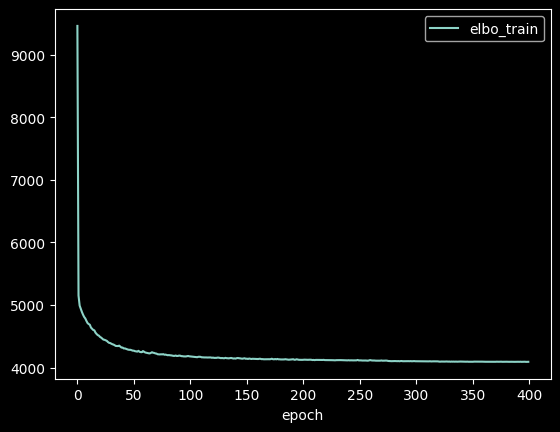

In [68]:
model.history["elbo_train"].plot()

In [ ]:
true_proteins = adata_test.obsm["protein_expression"]

In [70]:
_, protein_pred = model.get_normalized_expression(
    adata_test,
    n_samples=50,
    include_protein_background=True,
    sample_protein_mixing=False,
    return_mean=True,
)

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


In [96]:
rmse_per_protein = np.sqrt(
    np.mean((true_proteins - protein_pred) ** 2, axis=0)
)

for prot_name, rmse_val in zip(adata_test.uns["protein_names"], rmse_per_protein):
    if prot_name == "PCNA-1":print(f"{prot_name}: {rmse_val:.2f}")

PCNA-1: 562.61


## PTPRC breast cancer (visium 10x) example

In [ ]:
path = "/Users/lukar818/Documents/postdoc/MCAR/data/visiumbc" # set to location of visium 10x breast cancer

adata_all = sc.read_10x_mtx(
    os.path.join(path, "filtered_feature_bc_matrix"),
    var_names="gene_symbols",
    gex_only=False
)

In [117]:
json_data['visiumBC'].keys()

dict_keys(['PCNA', 'VIM', 'KRT', 'PTPRC', 'PAX5', 'BCL2', 'CD19', 'FCGR3A', 'CD3E', 'PECAM1'])

In [118]:
sc.pp.highly_variable_genes(
    adata_all,
    flavor="seurat_v3",
    n_top_genes=4000,
    subset=True
)

In [119]:
test_barcodes = np.array(json_data['visiumBC']['PTPRC'])
mask_test = np.isin(adata_all.obs_names, test_barcodes)
mask_train = ~mask_test

train_idx = np.where(mask_train)[0]
test_idx  = np.where(mask_test)[0]

rna = adata_all[:, adata_all.var["feature_types"] == "Gene Expression"]
prot = adata_all[:, adata_all.var["feature_types"] == "Antibody Capture"]

adata_train = ad.AnnData(
    X=rna.X[train_idx],
    obs=rna.obs.iloc[train_idx].copy(),
    var=rna.var.copy()
)
adata_train.obsm["protein_expression"] = prot.X[train_idx]
adata_train.uns["protein_names"] = prot.var_names.tolist()
adata_train.obs['batch'] = 'train'

adata_test = ad.AnnData(
    X=rna.X[test_idx],
    obs=rna.obs.iloc[test_idx].copy(),
    var=rna.var.copy()
)
adata_test.obsm["protein_expression"] = prot.X[test_idx]
adata_test.uns["protein_names"] = prot.var_names.tolist()
adata_test.obs['batch'] = 'train'

In [120]:
for ads in [adata_train, adata_test]:
    prot = ads.obsm["protein_expression"]

    if hasattr(prot, "toarray"):
        prot = prot.toarray()
        
    prot = (prot / 100).astype(int)

    ads.obsm["protein_expression"] = prot

In [121]:
scvi.model.TOTALVI.setup_anndata(
    adata_train,
    protein_expression_obsm_key="protein_expression"
)

scvi.model.TOTALVI.setup_anndata(
    adata_test,
    protein_expression_obsm_key="protein_expression"
)

INFO     Generating sequential column names                                                                        
INFO     Generating sequential column names                                                                        


/var/folders/rs/_rjl71n16bgcl_57zv22vzx00000gn/T/ipykernel_70077/4212774130.py:1: DeprecationWarning: We recommend using setup_mudata for multi-modal data.It does not influence model performance
  scvi.model.TOTALVI.setup_anndata(
/Users/lukar818/.pyenv/versions/3.13.5/envs/totalvi/lib/python3.13/site-packages/scvi/data/fields/_layer_field.py:115: UserWarning: Training will be faster when sparse matrix is formatted as CSR. It is safe to cast before model initialization.
  _verify_and_correct_data_format(adata, self.attr_name, self.attr_key)
/var/folders/rs/_rjl71n16bgcl_57zv22vzx00000gn/T/ipykernel_70077/4212774130.py:6: DeprecationWarning: We recommend using setup_mudata for multi-modal data.It does not influence model performance
  scvi.model.TOTALVI.setup_anndata(
/Users/lukar818/.pyenv/versions/3.13.5/envs/totalvi/lib/python3.13/site-packages/scvi/data/fields/_layer_field.py:115: UserWarning: Training will be faster when sparse matrix is formatted as CSR. It is safe to cast before 

In [122]:
model = scvi.model.TOTALVI(adata_train,
                           latent_distribution="normal",
                           n_layers_decoder=2)
model.train(max_epochs=400,
            accelerator='mps')

INFO     Computing empirical prior initialization for protein background.                                          


/Users/lukar818/.pyenv/versions/3.13.5/envs/totalvi/lib/python3.13/site-packages/scvi/train/_trainrunner.py:82: UserWarning: `accelerator` has been set to `mps`. Please note that not all PyTorch/Jax operations are supported with this backend. as a result, some models might be slower and less accurate than usuall. Please verify your analysis!Refer to https://github.com/pytorch/pytorch/issues/77764 for more details.
  accelerator, lightning_devices, device = parse_device_args(
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Users/lukar818/.pyenv/versions/3.13.5/envs/totalvi/lib/python3.13/site-packages/lightning/pytorch/core/optimizer.py:317: The lr scheduler dict contains the key(s) ['monitor'], but the keys will be ignored. You need to call `lr_scheduler.step()` manually in manual optimization.
/Users/lukar818/.pyenv/versions/3.13.5/envs/totalvi/lib/python3.13/site-packages/lightning/pytorch/trainer/connectors/data_con

Training:   0%|          | 0/400 [00:00<?, ?it/s]

Monitored metric elbo_validation did not improve in the last 45 records. Best score: 3707.496. Signaling Trainer to stop.


<Axes: xlabel='epoch'>

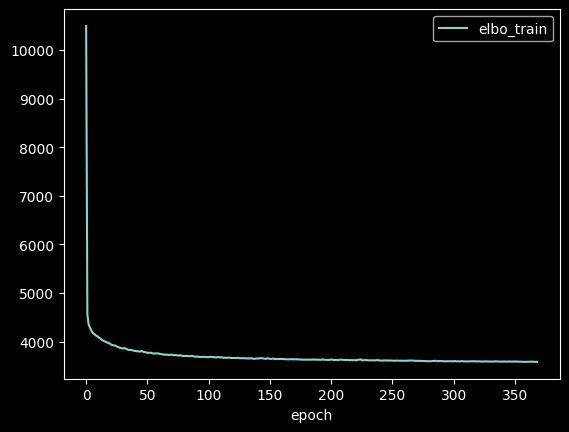

In [123]:
model.history["elbo_train"].plot()

In [124]:
true_proteins = adata_test.obsm["protein_expression"]

In [125]:
_, protein_pred = model.get_normalized_expression(
    adata_test,
    n_samples=50,
    include_protein_background=True,
    sample_protein_mixing=False,
    return_mean=True,
)

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/Users/lukar818/.pyenv/versions/3.13.5/envs/totalvi/lib/python3.13/site-packages/scvi/data/fields/_layer_field.py:115: UserWarning: Training will be faster when sparse matrix is formatted as CSR. It is safe to cast before model initialization.
  _verify_and_correct_data_format(adata, self.attr_name, self.attr_key)


In [130]:
rmse_per_protein = np.sqrt(
    np.mean((true_proteins - protein_pred) ** 2, axis=0)
)

for prot_name, rmse_val in zip(adata_test.uns["protein_names"], rmse_per_protein):
    if prot_name == "PTPRC-2":print(f"{prot_name}: {rmse_val:.2f}")

PTPRC-2: 391.77
